# Práctica 4: Entrenamiento de redes neuronales

### Jorge Villarrubia Elvira y Juan Carlos Villanueva Quirós

### 1) Función de coste
En esta primera parte calcularemos la función de coste de una red neuronal para un conjunto de ejemplos de entrenamiento. Cada ejemplo es una imagen 20x20, representado como un vector de 400 componentes que indica la intensidad del pixel en excala de grises. Cada imagen es un número del 0 al 9, que se tratará de clasficar, pero la imágenes de un "0" vienen etiquetadas con un "10". Se dispone de 5000 ejemplos de entrenamiento.

In [1]:
#importamos las librerias que utiizaremos
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import checkNNGradients as check
import displayData as disp
from scipy.optimize import minimize

Cargamos los datos de las 5000 imágenes del fichero ex4data1.mat. También las matrices de pesos $\Theta^{(1)}$ y $\Theta^{(2)}$, de tamaños 15x401 y 10x26 respectivamente, que están en el fichero ex4weights.mat, y son el resultado de entrenar una red neuronal para el problema poniendo 25 neuronas en la única capa oculta.

Aprovechamos para quitarles la última columna, que no ncesitaremos cuando las utilicemos para la regularización del coste.

In [2]:
weights = loadmat('ex4weights.mat')
Theta1Trained, Theta2Trained = weights['Theta1'], weights['Theta2']
layers = [Theta1Trained, Theta2Trained]
data = loadmat('ex4data1.mat')
# Convertimos la matriz y en un array unidimensional para evitar conflictos de dimensiones después
y = data['y'].ravel() # (5000, 1) --> (5000,)
X = data['X']

Elegimos 100 elementos aleatorios del conjunto de datos y con ayuda de la función
displayData proporcionada con la práctica los mostramos, para así comprobar que los datos se han cargado correctamente.

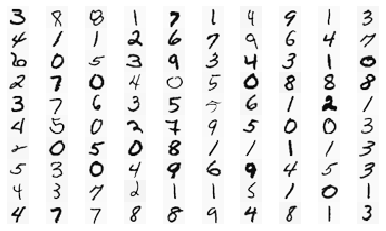

In [3]:
sample = np.random.choice(X.shape[0], 100)
disp.displayData(X[sample])
plt.show()

Seguidamente codificamos las etiquetas como vectores de 10 componentes, en lugar de que sean un escalar, para poder entrenar la red. Colocamos un 1 en la posición correspondiente al valor de la etiqueta y un 0 en las otras 9 componentes.

De esta forma:
- $(1,0,0,0,0,0,0,0,0,0)^{t}$ se correspondería con una etiqueta "1" (que es una imagen con número 1).
- $(0,1,0,0,0,0,0,0,0,0)^{t}$ se correspondería con una etiqueta "2" (que es una imagen con número 2).
- ...
- $(0,0,0,0,0,0,0,0,0,1)^{t}$ se correspondería con una etiqueta "10" (que es una imagen con número 0).

In [4]:
m = len(y)
input_size = X.shape[1]
num_labels = 10
y = (y - 1)
y_onehot = np.zeros((m, num_labels))  # 5000 x 10
for i in range(m):
    y_onehot[i][y[i]] = 1
y_onehot

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

Ahora ya sí, pasamos a implementar la funcion de coste de la red neuronal, teniendo en cuenta el término de regularización. Para ello necesitamos la función ***forwardPropagation*** de la práctica anterior, que ahora además devuelve en una matriz ***A*** los valores ***$a^{(i)}$*** que se calculan, pues serán útiles en la propagación hacia atrás.

La implemenatación de ***costeNeuronalRegu*** consisten en vectorizar el cálculo

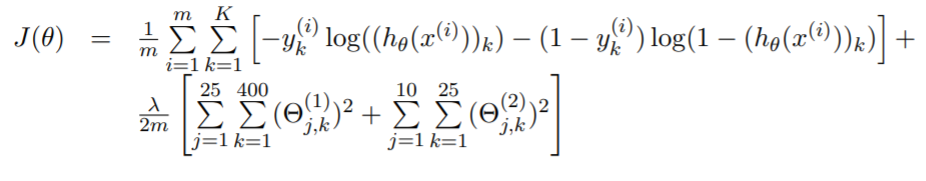

ayudándose de que las operaciones en numpy se hacen elemento a elemento y se hace broadcasting, además de que el vector ***y_onehot*** que recibirá la función de coste tiene un 1 en la posición que nos interesa multiplicar por la correspondiente posición de $log(h)$ y un 0 en las demás, con lo cuál al multiplicar esas quedará 0.

In [5]:
def forwardPropagation(X, layers):
    #La variable 'a' corresponde a la entrada de cada capa, que al principio seran los datos de entrada X.
    #Ojo: trasponemos para tratar las dimensiones correctamente
    m = X.shape[0]
    a = X
    A = []
    #Propagación hacia delante genérica que sirve para más de 2 matrices
    for i in range(len(layers)):
        #Añadimos unos a la entrada de cada capa (los terminos independientes)
        a = np.hstack([np.ones([m, 1]), a])
        
        A.append(a)
        
        #Cogemos los pesos correspondientes a la capa que toca
        thetas = layers[i]
        
        #Hacemos la multiplicacion
        z = np.matmul(a, thetas.T)
        
        #Y por ultimo la funcion de activacion
        a = sigmoide(z)
        
    A.append(a)
    #Al salir del bucle, tendremos la salida de la red neuronal
    #Trasponemos para devolver la misma forma que los datos de entrada
    return A, a

def sigmoide(z):
    return 1 / (1 + np.exp(-z))

def costeNeuronal(X, Y, layers):
    m = X.shape[0]
    _, h = forwardPropagation(X, layers)
    return np.sum(Y * np.log(h) + (1 - Y) * np.log(1-h))*-1/m

def costeNeuronalRegu(X,Y, layers, regu):
    _, h = forwardPropagation(X, layers)
    m = X.shape[0]
    reguTerm = 0
    # Para tantas matrices como nos pasen.
    # Así es genérico, en lugar de hacerlo para 2 matrices como en los apuntes
    for layer in layers:
        #Quitamos la última columna de 1's
        reguTerm += np.sum(layer[:,1:]**2)
    reguTerm *= regu/(2*m)
    return np.sum(Y * np.log(h) + (1 - Y) * np.log(1-h))*-1/m + reguTerm

Comprobamos que, efectivamente, en la versión sin regularizar se obtiene el valor de aproximadamente 0.287629 que indica el enunciado, y en la versión regularizada con $\lambda = 1$ se obtiene en torno a 0.383770

In [6]:
print('Coste sin regularizar:', costeNeuronal(X, y_onehot, layers))
print('Coste con lambda = 1:', costeNeuronalRegu(X, y_onehot, layers, 1))

Coste sin regularizar: 0.2876291651613189
Coste con lambda = 1: 0.38376985909092365


### 2) Cálculo del gradiente

Implementamos una función ***backprop*** que realice la propagación hacia atrás siguiendo el esquema visto en la teoría:

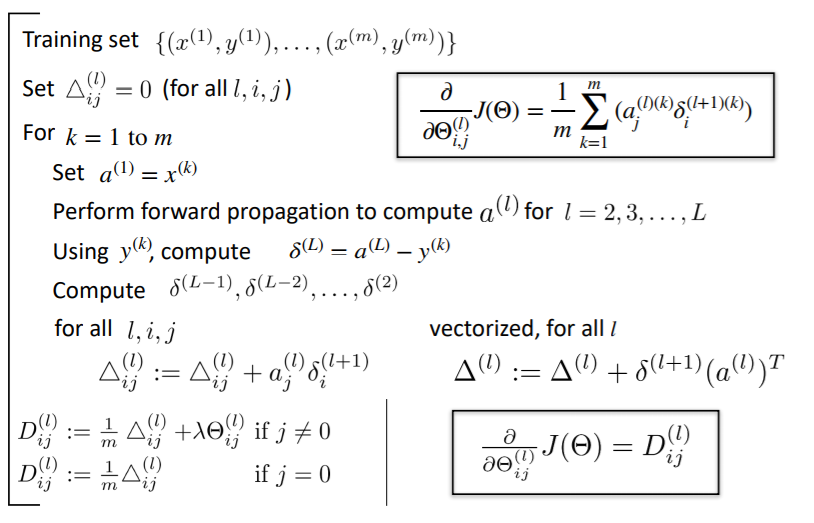

El resultado es una tupla con el coste según la función definida en la parte anterior de la práctica y las matrices gradiente aplanadas en un vector.

In [7]:
def backprop(params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    m = X.shape[0]
    Theta1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    Theta2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    layers = [Theta1, Theta2]
    A, _ = forwardPropagation(X, layers)
    Delta1 = np.zeros(Theta1.shape)
    Delta2 = np.zeros(Theta2.shape)
    for k in range(m):
        a1t = A[0][k]
        a2t = A[1][k]
        ht = A[2][k]
        y_t = y[k]
        d3t = ht - y_t
        d2t = np.dot(Theta2.T, d3t) * (a2t * (1 - a2t))
        Delta1 = Delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :])
        Delta2 = Delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :])
    coste = costeNeuronalRegu(X, y, layers, reg)
    Theta1Cero = np.copy(Theta1)
    Theta1Cero[:,0] = 0
    Theta2Cero = np.copy(Theta2)
    Theta2Cero[:,0] = 0
    D1 = Delta1/m + reg*Theta1Cero/m
    D2 = Delta2/m + reg*Theta2Cero/m
    return coste, np.r_[np.ravel(D1),np.ravel(D2)]

### 2.1) Comprobación del gradiente

Comprobamos con la función checkNNGradients que la propagación funciona correctamente pasandole nuestra implementación ***backprop***, que comprobará con una aproximación de las derivadas parciales para un problema sencillo

In [8]:
print('Máxima diferencia entre ambos gradientes:', max(abs(check.checkNNGradients(backprop, 0))))

grad shape:  (38,)
num grad shape:  (38,)
Máxima diferencia entre ambos gradientes: 1.268262439513279e-10


Y efectivamente, ambos gradientes son casi idénticos. Enla posición donde más, distan del orden de $10^{-10}$.

### 3) Aprendizaje de los parámetros

Vamos ya a entrenar la red neuronal para el conjunto de entrenamiento que cargmos al principio de la práctica. Para ello, necesitaremos inicializar los pesos a un valor que no sea idénticamente nulo. Implementamos la función ***initializeRandom*** que nos devuelve 2 matrices de pesos aleatorias, con los tamaños apropiados para usarlas inicialmente.

Y la llamamos para obtener matrices 25x401 y 10x26 que necesita nuestra red para empezar. Con valores aleatorios en el intervalo (-0.12,0.12).

Aplanamos dichas matrices en un vector para poder llamar a la función ***minimize*** de scipy.optimize, que nos devuelve los pesos óptimos en el objeto fmin, ayudandose de la función ***backprop*** que implementamos anteriormente, que le proporciona los gradientes para minimizar. Hacemos una minimización con un máximo de 70 iteraciones.

In [9]:
def initializeRandom(input_size, hidden_size, num_labels, INIT_EPSILON):
    Theta1 = np.random.random((hidden_size, input_size+1))*(2*INIT_EPSILON)- INIT_EPSILON
    Theta2 = np.random.random((num_labels, hidden_size+1)) *(2*INIT_EPSILON)- INIT_EPSILON
    return Theta1, Theta2

input_size = 400
hidden_size = 25
num_labels = 10
INIT_EPSILON = 0.12
Theta1_rand, Theta2_rand = initializeRandom(input_size,hidden_size, num_labels,INIT_EPSILON)
reg = 1
params = np.r_[np.ravel(Theta1_rand),np.ravel(Theta2_rand)]
fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size,num_labels, X, y_onehot, reg),method='TNC', jac=True,options={'maxiter': 70})

Finalmente obtenemos la precisión de predicciones para el conjunto de entrenamiento con los pesos óptimos obtenidos. Para ello, primero convertimos la matrices $\Theta^{(1)}$ y $\Theta^{(2)}$ que nos haya devuelto la minimización a sus correspondientes dimensiones (minimize devuelve un vector).

Y posteriormente llamamos a ***forwardPropagation*** para hacer predicción de los ejemplos de entrenamiento, que nos devolverá para cada ejemplo 10 valores numéricos con la probabilidad de que pertenezca a cada una de las 10 clases (números del 0 al 9).

Finalmente, comparando el valor más probable con la salida real obtenemos la precisión.

In [10]:
def precision(input_size, hidden_size, num_labels, thetaOpt, y):
    Theta1 = np.reshape(thetaOpt[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
    Theta2 = np.reshape(thetaOpt[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

    #Nuevamente, obtenemos la probabilidad para todos los ejemplos de entrenamiento, de que pertenezca a cada clase
    _, probability = forwardPropagation(X, [Theta1, Theta2])

    #Y volvemos a quedarnos con el indice que contiene la mayor probabilidad, ajustando correctamente los indices
    index = np.argmax(probability, axis=1)

    #Por ultimo, imprimimos por pantalla el porcentaje de ejemplos de entrenamiento que hemos clasificado correctamente
    return np.sum(index == np.ravel(y)) / len(y) * 100

print('Precisión obtenida: {}%'.format(precision(input_size, hidden_size, num_labels, fmin.x, y)))

Precisión obtenida: 91.14%


Que es de aproximadamente el 93% que decía el enunciado que debía obtenerse.

Para acabar, variamos el valor del parámetro de regularización $\lambda$ entre 0 y 20 a paso 2 en la minimización de pesos y calculamos la precisión. Representando el coste y la precisión para cada valor de $\lambda$

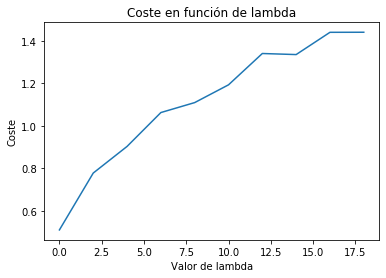

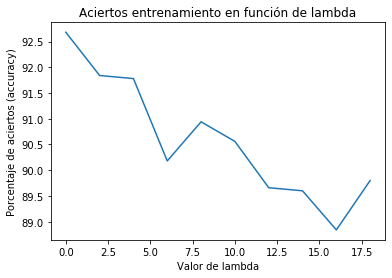

In [14]:
def testLamda(rango):
    input_size = 400
    hidden_size = 25
    num_labels = 10
    INIT_EPSILON = 0.12
    Theta1_rand, Theta2_rand = initializeRandom(input_size,hidden_size, num_labels,INIT_EPSILON)
    params = np.r_[np.ravel(Theta1_rand),np.ravel(Theta2_rand)]
    
    costes_lamda = []
    precision_lamda = []
    for lamda in rango:
        fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size,num_labels, X, y_onehot, lamda),method='TNC', jac=True,options={'maxiter': 70})
        costes_lamda.append(fmin.fun)
        prec = precision(input_size, hidden_size, num_labels, fmin.x, y)
        precision_lamda.append(prec)

    plt.plot(rango, costes_lamda)
    plt.xlabel('Valor de lambda')
    plt.ylabel('Coste')
    plt.title('Coste en función de lambda')
    plt.show()
    
    plt.plot(rango, precision_lamda)
    plt.xlabel('Valor de lambda')
    plt.ylabel('Porcentaje de aciertos (accuracy)')
    plt.title('Aciertos entrenamiento en función de lambda')
    plt.show()
    
testLamda(np.arange(0,20,2))

Observamos que con valores de $\lambda$ más pequeños (el caso extremo es que $\lambda = 0$ y ni siquiera haya regulariación), menos se minimiza el coste y la precisión precisión, en general, es más alta, lo cuál puede redundar en sobreaprendizaje si el valor de $\lambda$ es excesivamente pequeño (probablemente no funcione tan bien con datos nuevos porque si se "pega" demasiado a los de entrenamiento). Y con valores muy altos de $\lambda$ el aprendizaje empieza a ser demasiado escaso y la precisión demasiado baja.

En sucesivas ejecuciones observamos resultados distintos. En algunas sale favorecido un valor de $\lambda$ y en otras otro Esto es por la aleatoriedad de los pesos iniciales.

Hacemos lo propio con el número de iteraciones. Moviendo el valor de 70 a 200 de 10 en 10. Dejamos fijo el valor de $\lambda = 1$ que ya vimos que era el que mejor precisión nos daba.

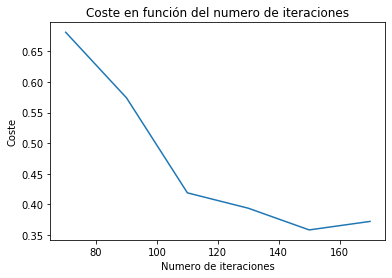

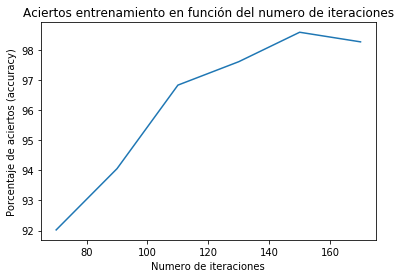

In [13]:
def testIter(rango):
    input_size = 400
    hidden_size = 25
    num_labels = 10
    INIT_EPSILON = 0.12
    lamda = 1
    Theta1_rand, Theta2_rand = initializeRandom(input_size,hidden_size, num_labels,INIT_EPSILON)
    params = np.r_[np.ravel(Theta1_rand),np.ravel(Theta2_rand)]
    
    costes_lamda = []
    precision_lamda = []
    for iterac in rango:
        fmin = minimize(fun=backprop, x0=params, args=(input_size, hidden_size,num_labels, X, y_onehot, lamda),method='TNC', jac=True,options={'maxiter': iterac})
        costes_lamda.append(fmin.fun)
        prec = precision(input_size, hidden_size, num_labels, fmin.x, y)
        precision_lamda.append(prec)

    plt.plot(rango, costes_lamda)
    plt.xlabel('Numero de iteraciones')
    plt.ylabel('Coste')
    plt.title('Coste en función del numero de iteraciones')
    plt.show()
    
    plt.plot(rango, precision_lamda)
    plt.xlabel('Numero de iteraciones')
    plt.ylabel('Porcentaje de aciertos (accuracy)')
    plt.title('Aciertos entrenamiento en función del numero de iteraciones')
    plt.show()
    
testIter(np.arange(70,190,20))

Observamos cómo, claramente, un aumento de las iteraciones máximas aumenta el número de aciertos sobre el conjunto de entrenamiento y permite minimizar mucho más el coste. Y de nuevo puede provocar sobreaprendizaje, incluso de manera más clara que para valor de $\lambda$, porque con muchas iteraciones (en torno a las 150) ya se ha alcanzado casi un 99% de acierto sobre el conjunto de enrenamiento, lo cuál hace presagiar que se está pegando demasiado a esos datos. Mientras que con pocas (unas 70 iteraciones) estamos en un 92%.  Habría que probar sobre datos de test que desconozca, para elegir $\lambda$ y el nº de iteraciones.